In [3]:
import sys ; sys.path.append('../')
import torch.optim as optim
import torch
import seaborn as sb
import pytorch_lightning as pl
import numpy as np
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import time

from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from learn_KKL.luenberger_observer import LuenbergerObserver
from learn_KKL.system import RevDuffing
from learn_KKL.learner import Learner
from learn_KKL.raffinement_dimN import *
#sb.set_style('whitegrid')
import matplotlib.pyplot as plt

In [2]:
# Set up the system
system = RevDuffing()
# Instantiate the observer
observer = LuenbergerObserver(dim_x=2, dim_y=1, method='Supervised', recon_lambda=0.8, wc=0.03,
                              activation=torch.nn.SiLU())
observer.set_dynamics(system)
# Generate initial dataset
data,grid = observer.generate_data_svl(np.array([[-1, 1.], [-1., 1.]]), [30,30],
                                  method='adaptative')

In [5]:
# Generate the test dataset
data_test,grid_test = observer.generate_data_svl(np.array([[-1, 1.], [-1., 1.]]), [80,80],
                                  method='adaptative')

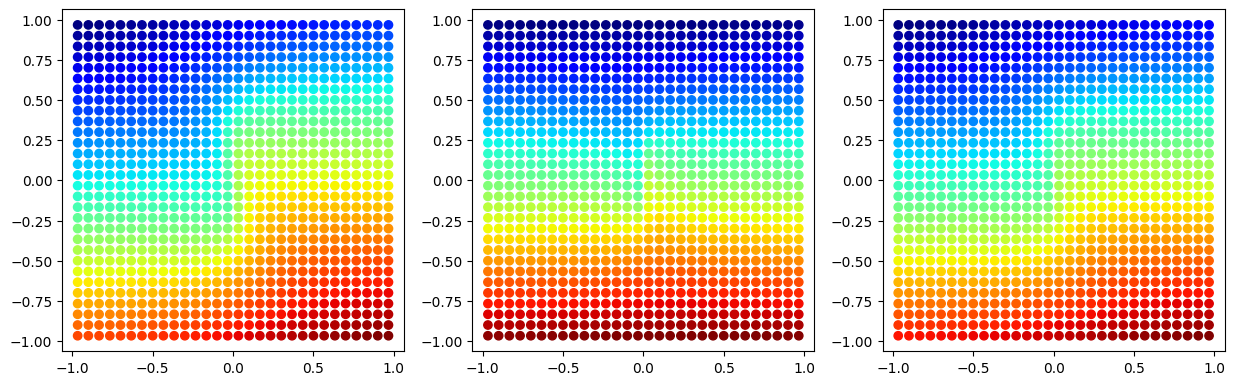

In [4]:
im,ax = plt.subplots(1,3,figsize=(15,15))
for i in range(3):
    ax[i].scatter(data[:,0],data[:,1],c = data[:,2+i],cmap='jet')
    ax[i].axis('square')
plt.show()

In [6]:
data_init, val_data_init = train_test_split(data, test_size=0.3, shuffle=True)

In [7]:
# Train T and T* over the initial dataset
# Options for training
num_hl = 2
size_hl = 20
trainer_options={'max_epochs': 15}
optimizer_options = {'weight_decay': 1e-6}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
learner_T = Learner(observer=observer, system=system, training_data=data_init,
                    validation_data=val_data_init, method='T', batch_size=10,
                    lr=1e-3, optimizer=optim.Adam,
                    optimizer_options=optimizer_options,
                    scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                    scheduler_options=scheduler_options)
# Define logger and checkpointing
logger = TensorBoardLogger(save_dir=learner_T.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger,
    log_every_n_steps=1, check_val_every_n_epoch=3)

trainer.fit(learner_T)

# Train the inverse transformation using pytorch-lightning and the learner class
# Options for training
trainer_options={'max_epochs': 15}
optimizer_options = {'weight_decay': 1e-8}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
learner_T_star = Learner(observer=observer, system=system, training_data=data_init,
                         validation_data=val_data_init, method='T_star',
                         batch_size=10, lr=5e-4, optimizer=optim.Adam,
                         optimizer_options=optimizer_options,
                         scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                         scheduler_options=scheduler_options)

# Define logger and checkpointing
logger1 = TensorBoardLogger(save_dir=learner_T_star.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger,
    log_every_n_steps=1, check_val_every_n_epoch=3)

trainer.fit(learner_T_star)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T\exp_69/tb_logs\lightning_logs

  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 26.1 K
---------------------------------------------
13.1 K    Trainable params
13.1 K    Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Results saved in in C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T\exp_69


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:495: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the nu

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Epoch 00011: reducing learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:611: UserWarning: Checkpoint directory C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T\exp_69/tb_logs\lightning_logs\version_0\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 26.1 K
---------------------------------------------
13.1 K    Trainable params
13.1 K    Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Results saved in in C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_48


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 5.0000e-05.


Validation: 0it [00:00, ?it/s]

Epoch 00011: reducing learning rate of group 0 to 5.0000e-06.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

RMSE :  [0.00720254 0.00074086]


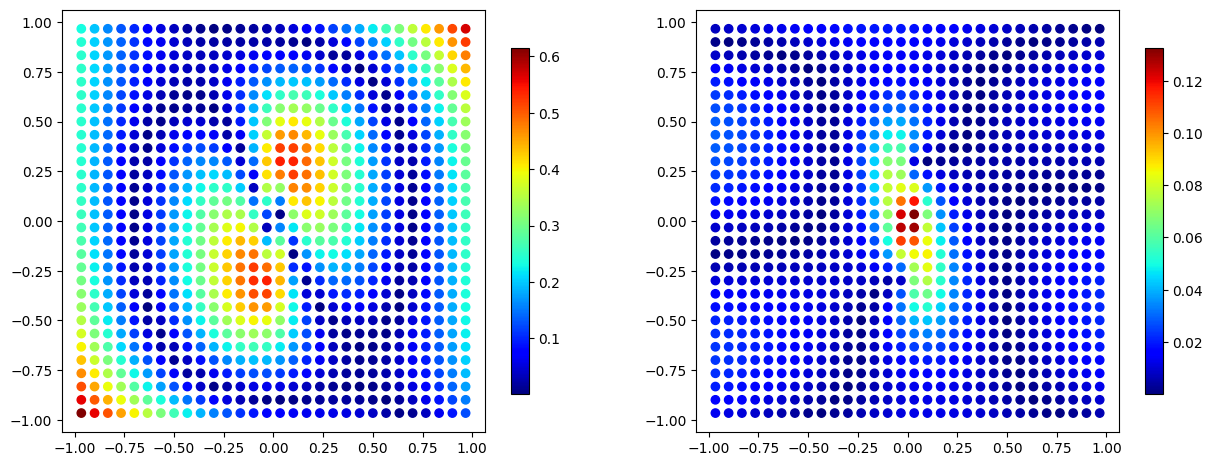

In [8]:
# Compute the prediction error over the initial dataset - The error is used for the refinement criterium
x_state = data[:,0:2]
x_state = torch.as_tensor(x_state)
z_state = data[:,2:5]
z_state = torch.as_tensor(z_state)

x_hat = observer.decoder(z_state).detach()
error = torch.abs(x_state-x_hat)
rmse = np.array([torch.sqrt((error[:,0]**2).sum()),torch.sqrt((error[:,1]**2).sum())])/error[:,0].size()
print("RMSE : ",rmse)

vmin1,vmax1,vmin2,vmax2 = error[:,0].min(),error[:,0].max(),error[:,1].min(),error[:,1].max()

im,ax = plt.subplots(1,2,figsize=(15,15))
for i in range(2):
    pc=ax[i].scatter(x_state[:,0],x_state[:,1],c = error[:,i],cmap='jet')
    ax[i].axis('square')
    im.colorbar(pc,ax=ax[i],shrink=0.3)
plt.show()

In [9]:
# refine the initial dataset with the criterium
critere1 = error[:,0]
critere2 = error[:,1]
data1,grid1 = observer.raffine_grid(grid,critere1)
data2,grid2 = observer.raffine_grid(grid,critere2)

torch.Size([2004, 5])
torch.Size([2184, 5])


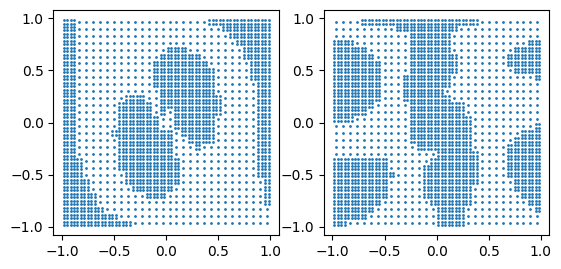

In [10]:
# We obtain 2 new grids, the first to train x1 and the second to train x2
print(data1.shape)
print(data2.shape)
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.scatter(data1[:,0],data1[:,1],s=1)
ax1.axis('square')
ax2.scatter(data2[:,0],data2[:,1],s=1)
ax2.axis('square')
plt.show()

In [11]:
data_x1, val_data_x1 = train_test_split(data1, test_size=0.3, shuffle=True)
data_x2, val_data_x2 = train_test_split(data2, test_size=0.3, shuffle=True)

In [12]:
# Train T* over the new refined dataset
# Options for training
trainer_options={'max_epochs': 15}
optimizer_options = {'weight_decay': 1e-8}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
learner_T_star = Learner(observer=observer, system=system, training_data=data_x1,
                         validation_data=val_data_x1, method='T_star',
                         batch_size=10, lr=5e-4, optimizer=optim.Adam,
                         optimizer_options=optimizer_options,
                         scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                         scheduler_options=scheduler_options)

# Define logger and checkpointing
logger1 = TensorBoardLogger(save_dir=learner_T_star.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger,
    log_every_n_steps=1, check_val_every_n_epoch=3)

trainer.fit(learner_T_star)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 26.1 K
---------------------------------------------
13.1 K    Trainable params
13.1 K    Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Results saved in in C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_48


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 5.0000e-05.


Validation: 0it [00:00, ?it/s]

Epoch 00011: reducing learning rate of group 0 to 5.0000e-06.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00015: reducing learning rate of group 0 to 5.0000e-07.


RMSE :  [0.00241139 0.00026009]


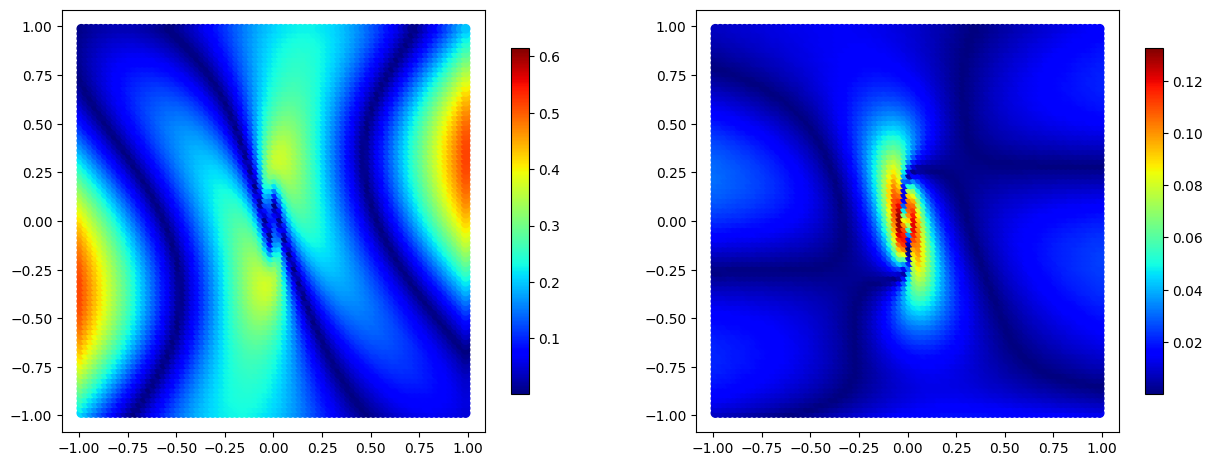

In [13]:
# Compute the prediction error over the training dataset
x_state = data_test[:,0:2]
x_state = torch.as_tensor(x_state)
z_state = data_test[:,2:5]
z_state = torch.as_tensor(z_state)

x_hat = observer.decoder(z_state).detach()
error = torch.abs(x_state-x_hat)
rmse = np.array([torch.sqrt((error[:,0]**2).sum()),torch.sqrt((error[:,1]**2).sum())])/error[:,0].size()
print("RMSE : ",rmse)

# vmin1,vmax1,vmin2,vmax2 = error[:,0].min(),error[:,0].max(),error[:,1].min(),error[:,1].max()

im,ax = plt.subplots(1,2,figsize=(15,15))
pc=ax[0].scatter(x_state[:,0],x_state[:,1],c = error[:,0],cmap='jet',vmin=vmin1,vmax=vmax1)
ax[0].axis('square')
im.colorbar(pc,ax=ax[0],shrink=0.3)
pc=ax[1].scatter(x_state[:,0],x_state[:,1],c = error[:,1],cmap='jet',vmin=vmin2,vmax=vmax2)
ax[1].axis('square')
im.colorbar(pc,ax=ax[1],shrink=0.3)
plt.show()

In [14]:
# Training uniform dataset with equal number of points
data_uni,_ = observer.generate_data_svl(np.array([[-1, 1.], [-1., 1.]]), [len(grid1),1],
                                  method='uniform')
print(data_uni.shape)

Computed the smallest possible uniform grid for the given dimensions, then deleted 21 samples randomly to match the desired number of samples 2004.
torch.Size([2004, 5])


In [15]:
data_uni_x1, val_data_uni = train_test_split(data_uni, test_size=0.3, shuffle=True)

In [16]:
# Train  T* over the equivalent uniform dataset
# Options for training
trainer_options={'max_epochs': 15}
optimizer_options = {'weight_decay': 1e-8}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
learner_T_star = Learner(observer=observer, system=system, training_data=data_uni_x1,
                         validation_data=val_data_uni, method='T_star',
                         batch_size=10, lr=5e-4, optimizer=optim.Adam,
                         optimizer_options=optimizer_options,
                         scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                         scheduler_options=scheduler_options)

# Define logger and checkpointing
logger1 = TensorBoardLogger(save_dir=learner_T_star.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger1,
    log_every_n_steps=1, check_val_every_n_epoch=3)

trainer.fit(learner_T_star)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_48/tb_logs\lightning_logs

  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 26.1 K
---------------------------------------------
13.1 K    Trainable params
13.1 K    Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Results saved in in C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_48


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 5.0000e-05.


Validation: 0it [00:00, ?it/s]

Epoch 00011: reducing learning rate of group 0 to 5.0000e-06.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

RMSE :  [0.00230093 0.00025103]


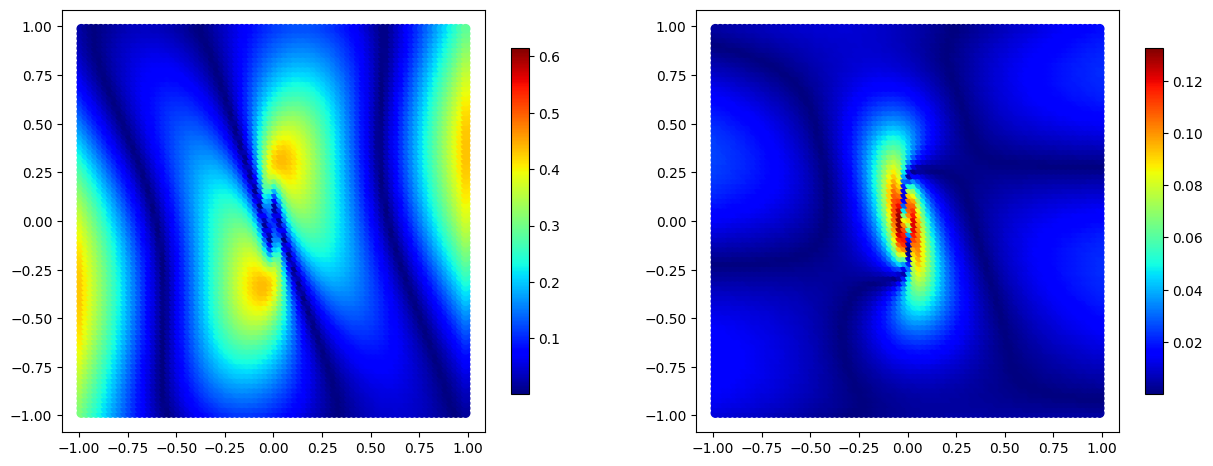

In [17]:
# Compute the prediction error over the training dataset
x_state = data_test[:,0:2]
x_state = torch.as_tensor(x_state)
z_state = data_test[:,2:5]
z_state = torch.as_tensor(z_state)

x_hat = observer.decoder(z_state).detach()
error = torch.abs(x_state-x_hat)
rmse = np.array([torch.sqrt((error[:,0]**2).sum()),torch.sqrt((error[:,1]**2).sum())])/error[:,0].size()
print("RMSE : ",rmse)

# vmin1,vmax1,vmin2,vmax2 = error[:,0].min(),error[:,0].max(),error[:,1].min(),error[:,1].max()

im,ax = plt.subplots(1,2,figsize=(15,15))
pc=ax[0].scatter(x_state[:,0],x_state[:,1],c = error[:,0],cmap='jet',vmin=vmin1,vmax=vmax1)
ax[0].axis('square')
im.colorbar(pc,ax=ax[0],shrink=0.3)
pc=ax[1].scatter(x_state[:,0],x_state[:,1],c = error[:,1],cmap='jet',vmin=vmin2,vmax=vmax2)
ax[1].axis('square')
im.colorbar(pc,ax=ax[1],shrink=0.3)
plt.show()